In [2]:
from sentence_transformers import SentenceTransformer, SentencesDataset, util, SentencesDataset, InputExample, losses
from torch.utils.data import DataLoader
import torch
import numpy as np

In [2]:
model_untuned = SentenceTransformer("neuralmind/bert-base-portuguese-cased")
model_tuned = SentenceTransformer("../tuning/model/")

# 1. Fine-tuning

## 1.1 Preparação dos dados

In [3]:
import pandas as pd

arvore_proposicoes = pd.read_csv("../data/arvore-proposicoes.csv", encoding="utf-8")
df_2019 = pd.read_csv("../data/proposicao-tema-completo-sem-duplicado-2019-all-fields.csv")
df_assunto = pd.read_csv("../data/pesquisas.csv", encoding="utf-8", delimiter=";")

In [4]:
df_2019.dropna(inplace=True)
print(df_2019.shape)
df_2019.head()

(3698, 13)


,codProposicao,txtNome,txtEmenta,txtExplicacaoEmenta,txtIndexacao,imgArquivoTeorPDF,idTema,txtProposicaoComJustificacao,txtProposicaoSemJustificacao,txtJustificacao,txtEmentaProposicaoSemJustificacao,txtEmentaKeywords,txtEmentaProposicaoSemJustificacaoKeywords
1,317970,PL 2037/2019 ...,"Altera a Lei nº 8.666, de 21 de junho de 1993,...",...,"Alteração, Lei das Licitações, proibição, ante...","PROJETO DE LEI No , DE 2006\r\n(...",34,O CONGRESSO NACIONAL decreta:\r\nArt. 1º A a...,O CONGRESSO NACIONAL decreta:\r\nArt. 1º A a...,JUSTIFICAÇÃO\r\nConsoante investigações promo...,"""Altera a Lei nº 8.666, de 21 de junho de 1993...","""Altera a Lei nº 8.666, de 21 de junho de 1993...","""Altera a Lei nº 8.666, de 21 de junho de 1993..."
2,427339,PL 2439/2019 ...,"Altera o art. 125 da Lei nº 9.279, de 14 de ma...",...,"Alteração, Nova Lei de Patentes, critérios, re...","PROJETO DE LEI No , DE 2009\r\n(Do...",66,O CONGRESSO NACIONAL decreta:\r\nArt. 1º O ar...,O CONGRESSO NACIONAL decreta:\r\nArt. 1º O ar...,JUSTIFICAÇÃO\r\nO antigo Código da Propriedad...,"""Altera o art. 125 da Lei nº 9.279, de 14 de m...","""Altera o art. 125 da Lei nº 9.279, de 14 de m...","""Altera o art. 125 da Lei nº 9.279, de 14 de m..."
3,501638,PL 402/2019 ( ...,Institui o Programa Cidade Amiga do Idoso. ...,...,"Criação, Programa Cidade Amiga do Idoso, quali...","PROJETO DE LEI no , DE 2011 \r\n(Do Sr. ...",44,O CONGRESSO NACIONAL decreta: \r\nArt. 1º Fic...,O CONGRESSO NACIONAL decreta: \r\nArt. 1º Fic...,JUSTIFICAÇÃO \r\nAs pessoas idosas em nosso p...,"""Institui o Programa Cidade Amiga do Idoso. ...","""Institui o Programa Cidade Amiga do Idoso. ...","""Institui o Programa Cidade Amiga do Idoso. ..."
4,512431,PL 2442/2019 ...,Proíbe a utilização de mensagens subliminares ...,"Altera a Lei nº 4.117, de 1962 ...","Alteração, Código Brasileiro de Telecomunicaçõ...",\r\n \r\nCÂMARA DOS DEPUTADOS \r\n \r\nPROJET...,37,O CONGRESSO NACIONAL decreta: \r\n \r\nArt. 1...,O CONGRESSO NACIONAL decreta: \r\n \r\nArt. 1...,JUSTIFICAÇÃO \r\nAs emissoras de radiodifusão...,"""Proíbe a utilização de mensagens subliminares...","""Proíbe a utilização de mensagens subliminares...","""Proíbe a utilização de mensagens subliminares..."
5,530357,PL 2440/2019 ...,Obriga os fabricantes de aparelho celular a di...,...,"Obrigatoriedade, fabricante, assistência técni...","PROJETO DE LEI Nº , DE 2011 \r\n(Da Sra. ...",67,O CONGRESSO NACIONAL decreta: \r\nArt. 1º Est...,O CONGRESSO NACIONAL decreta: \r\nArt. 1º Est...,JUSTIFICAÇÃO \r\nO Código de Defesa do Consum...,"""Obriga os fabricantes de aparelho celular a d...","""Obriga os fabricantes de aparelho celular a d...","""Obriga os fabricantes de aparelho celular a d..."


In [5]:
df_assunto

,NÚMERO-PROPOSIÇÃOSILEG,TxtAssunto
0,PEC 151/2019,Solicito a consultoria elaboração de Projeto d...
1,PL 1036/2019,"tese Conamat (arts. 545, 582 e 602 da CLT ..."
2,PL 1037/2019,art. 394-A da CLT - insalubridade trabalhadora...
3,PL 1075/2019,"Solicito a analise do Projeto de Lei, anexo, p..."
4,PL 1076/2019,Elaboração de Lei Federal que obrigue todos os...
...,...,...
290,PL 914/2019,Preparar Projeto de Lei para tratar da destina...
291,PL 927/2019,Obriga as instituições e comércios a expor os...
292,PL 947/2019,SOLICITO A FEITURA DE UM PROJETO DE LEI QUE PE...
293,PL 993/2019,"Solicito reelaboração do PL 10235/2018, para r..."


# 2. Teste

Realizando comparação entre modelo com e sem tuning

In [7]:
corpus = df_2019["txtEmenta"].to_numpy()
corpus_embeddings_untuned = model_untuned.encode(corpus, convert_to_tensor=True)
corpus_embeddings_tuned = model_tuned.encode(corpus, convert_to_tensor=True)

queries = df_assunto["TxtAssunto"].to_numpy()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [8]:
def get_name(df, doc, in_field="content", out_field = "name"):
    return str(df[df[in_field]==doc][out_field].to_numpy()[0]).strip()

In [9]:
top_k = 100
res_vector_untuned = list()
res_vector_tuned = list()
for query in queries:
    try:
        query_embedding_untuned = model_untuned.encode(query, convert_to_tensor=True)
        query_embedding_tuned = model_tuned.encode(query, convert_to_tensor=True)
        
        cos_scores_untuned = util.pytorch_cos_sim(query_embedding_untuned, corpus_embeddings_untuned)[0]
        cos_scores_tuned = util.pytorch_cos_sim(query_embedding_tuned, corpus_embeddings_tuned)[0]
        
        top_results_untuned = torch.topk(cos_scores_untuned, k=top_k)
        top_results_tuned = torch.topk(cos_scores_tuned, k=top_k)
        
        top_resuts_txt_untuned = [get_name(df_2019, txt, in_field="txtEmenta", out_field="txtNome").strip() for txt in corpus[top_results_untuned[1].numpy()]]
        top_resuts_txt_tuned = [get_name(df_2019, txt, in_field="txtEmenta", out_field="txtNome").strip() for txt in corpus[top_results_tuned[1].numpy()]]
        
        res_vector_untuned.append([get_name(df_assunto, query, "TxtAssunto", "NÚMERO-PROPOSIÇÃOSILEG").strip(), top_resuts_txt_untuned])
        res_vector_tuned.append([get_name(df_assunto, query, "TxtAssunto", "NÚMERO-PROPOSIÇÃOSILEG").strip(), top_resuts_txt_tuned])
    except:
        print("ERRO ao realizar encoding")
        pass

ERRO ao realizar encoding
ERRO ao realizar encoding
ERRO ao realizar encoding
ERRO ao realizar encoding
ERRO ao realizar encoding
ERRO ao realizar encoding


In [10]:
print(f"% queries processadas: {len(res_vector_untuned)/len(queries)}")

% queries processadas: 0.9796610169491525


In [13]:
res_v_untuned = list()
for k in range(top_k):
    results = list()
    for target, docs in res_vector_untuned:
        if (target in docs[:k]):
            results.append(1)
        else:
            results.append(0)
    res_v_untuned.append(sum(results)/len(results))

In [12]:
res_v_tuned = list()
for k in range(top_k):
    results = list()
    for target, docs in res_vector_tuned:
        if (target in docs[:k]):
            results.append(1)
        else:
            results.append(0)
    res_v_tuned.append(sum(results)/len(results))

In [3]:
with open("bm25.npy", "rb") as f:
    bm25 = np.load(f)

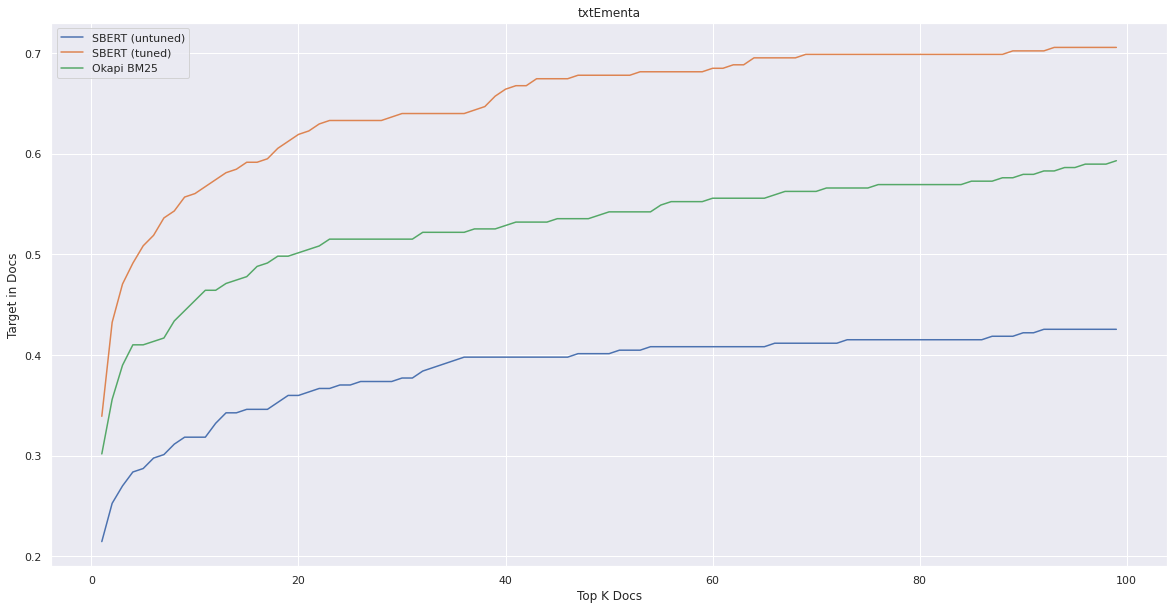

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.figure(figsize=(20,10))
plt.plot(np.arange(1,100), res_v_untuned[1:], label="SBERT (untuned)")
plt.plot(np.arange(1,100), res_v_tuned[1:], label="SBERT (tuned)")
plt.plot(np.arange(1,100), bm25, label="Okapi BM25")

plt.title("txtEmenta")
plt.legend()
plt.xlabel("Top K Docs")
plt.ylabel("Target in Docs")

plt.show()